# Week 4: Multi-class Classification

In [1]:
# Disable Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [2]:
!pip install gdown==5.1.0

In [3]:
# grader-required-cell

import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

2024-07-05 07:49:47.552159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 07:49:47.552266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 07:49:47.664794: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /kaggle/working/sign_mnist_train.csv
100%|███████████████████████████████████████| 83.3M/83.3M [00:00<00:00, 200MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /kaggle/working/sign_mnist_test.csv
100%|███████████████████████████████████████| 21.8M/21.8M [00:00<00:00, 113MB/s]


In [5]:
# grader-required-cell

TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

In [6]:
# grader-required-cell

with open(TRAINING_FILE) as training_file:
    line = training_file.readline()
    print(f"First line (header) looks like this:\n{line}")
    line = training_file.readline()
    print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

In [7]:
# GRADED FUNCTION: parse_data_from_input
def parse_data_from_input(filename):
  with open(filename) as file:
    ### START CODE HERE

    # Use csv.reader, passing in the appropriate delimiter
    # Remember that csv.reader can be iterated and returns one line in each iteration
    csv_reader = csv.reader(file, delimiter=',')

    labels = []
    images = []

    # Skip header
    next(csv_reader, None)

    for row in csv_reader:
      label = row[0]
      image = row[1:]
      image = np.reshape(image, (28, 28))

      labels.append(label)
      images.append(image)
    
    labels = np.array(labels).astype('float')
    images = np.array(images).astype('float')

    ### END CODE HERE

    return images, labels

In [8]:
# grader-required-cell

# Test your function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


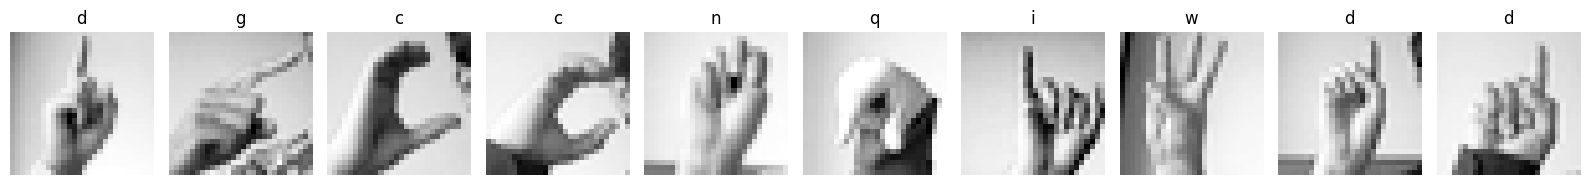

In [9]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
    fig, axes = plt.subplots(1, 10, figsize=(16, 15))
    axes = axes.flatten()
    letters = list(string.ascii_lowercase)

    for k in range(10):
        img = training_images[k]
        img = np.expand_dims(img, axis=-1)
        img = array_to_img(img)
        ax = axes[k]
        ax.imshow(img, cmap="Greys_r")
        ax.set_title(f"{letters[int(training_labels[k])]}")
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

plot_categories(training_images, training_labels)

In [10]:
# grader-required-cell

# GRADED FUNCTION: train_val_generators
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
    
    ### START CODE HERE

    # In this section you will have to add another dimension to the data
    # So, for example, if your array is (10000, 28, 28)
    # You will need to make it (10000, 28, 28, 1)
    # Hint: np.expand_dims
    training_images = np.expand_dims(training_images, axis = -1)
    validation_images = np.expand_dims(validation_images, axis = -1)

    # Instantiate the ImageDataGenerator class 
    # Don't forget to normalize pixel values 
    # and set arguments to augment the images (if desired)
    train_datagen = ImageDataGenerator(
        rescale = 1.0/255.0,
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest'
    )


    # Pass in the appropriate arguments to the flow method
    train_generator = train_datagen.flow(x = training_images,
                                       y = training_labels,
                                       batch_size = 32) 


    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    # Remember that validation data should not be augmented
    validation_datagen = ImageDataGenerator(rescale = 1.0/255.0)

    # Pass in the appropriate arguments to the flow method
    validation_generator = validation_datagen.flow(x = validation_images,
                                                 y = validation_labels,
                                                 batch_size=32) 

    ### END CODE HERE

    return train_generator, validation_generator

In [11]:
# Test your generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


In [17]:
# grader-required-cell

def create_model():

    ### START CODE HERE       

    # Define the model
    # Use no more than 2 Conv2D and 2 MaxPooling2D
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(26, activation='softmax')
    ])


    model.compile(optimizer = tf.optimizers.Adam(),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

    ### END CODE HERE       

    return model

In [18]:
model = create_model()

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,362 (399.85 KB)

 Trainable params: 102,362 (399.85 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(train_generator,
                   epochs = 100,
                   validation_data = validation_generator)

Epoch 1/100


2024-07-05 07:54:47.827096: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.35363, expected 1.53764
2024-07-05 07:54:47.827158: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.82107, expected 1.00508
2024-07-05 07:54:47.827173: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.81936, expected 1.00338
2024-07-05 07:54:47.827191: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.23827, expected 1.42229
2024-07-05 07:54:47.827204: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.05481, expected 2.23883
2024-07-05 07:54:47.827215: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.58554, expected 1.76955
2024-07-05 07:54:47.827226: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.00002, expected 2.18403
2024-07-05 07:54:47.827237: E external/local_xla/xla/se

274/858 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0483 - loss: 3.1872

2024-07-05 07:54:52.848820: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27: 1.60929, expected 1.33846
2024-07-05 07:54:52.848878: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28: 1.44168, expected 1.17084
2024-07-05 07:54:52.848887: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 1.67805, expected 1.40722
2024-07-05 07:54:52.848895: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 58: 1.54853, expected 1.27769
2024-07-05 07:54:52.848903: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 76: 1.59255, expected 1.32172
2024-07-05 07:54:52.848912: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 1.63052, expected 1.35969
2024-07-05 07:54:52.848920: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 248: 1.26245, expected 0.991619
2024-07-05 07:54:52.848928: E external/local_

858/858 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.0834 - loss: 3.0230 - val_accuracy: 0.2117 - val_loss: 2.3420
Epoch 2/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.2686 - loss: 2.2668 - val_accuracy: 0.3434 - val_loss: 1.9831
Epoch 3/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.4069 - loss: 1.8099 - val_accuracy: 0.5303 - val_loss: 1.2445
Epoch 4/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.4821 - loss: 1.5479 - val_accuracy: 0.5950 - val_loss: 1.0936
Epoch 5/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5455 - loss: 1.3488 - val_accuracy: 0.6987 - val_loss: 0.8511
Epoch 6/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5926 - loss: 1.2073 - val_accuracy: 0.6602 - val_loss: 0.9272
Epoch 7/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6295 - loss: 1.1093 - val_accuracy: 0.7453 - val_loss: 0.7470
Epoch 8/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6633 - loss: 0.9919 - val_

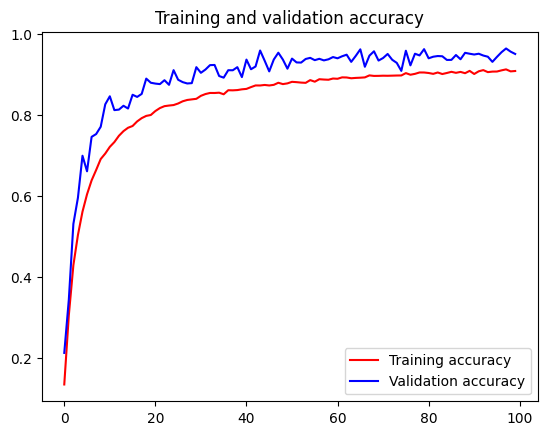

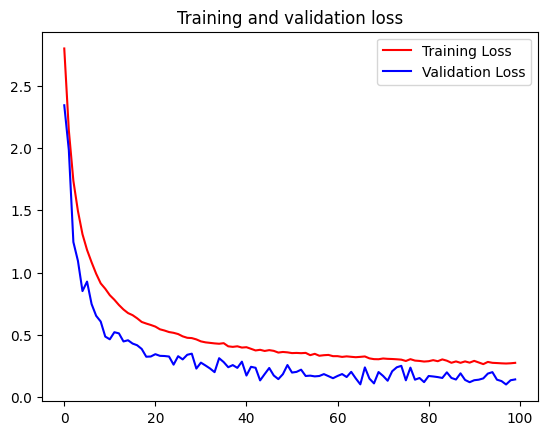

In [21]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()